In [1]:
#!pip install openml --quiet

In [2]:
# import openml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

## Section 1: Reading the data

In [3]:
# X, y, _, _ = openml.datasets.get_dataset(42750).get_data(dataset_format="dataframe")
# df = X.copy()
df = pd.read_csv('Census-Income-KDD.csv')
print(df.shape)

(199523, 42)


In [4]:
df.columns

Index(['age', 'class_worker', 'det_ind_code', 'det_occ_code', 'education',
       'wage_per_hour', 'hs_college', 'marital_stat', 'major_ind_code',
       'major_occ_code', 'race', 'hisp_origin', 'sex', 'union_member',
       'unemp_reason', 'full_or_part_emp', 'capital_gains', 'capital_losses',
       'stock_dividends', 'tax_filer_stat', 'region_prev_res',
       'state_prev_res', 'det_hh_fam_stat', 'det_hh_summ', 'unknown',
       'mig_chg_msa', 'mig_chg_reg', 'mig_move_reg', 'mig_same',
       'mig_prev_sunbelt', 'num_emp', 'fam_under_18', 'country_father',
       'country_mother', 'country_self', 'citizenship', 'own_or_self',
       'vet_question', 'vet_benefits', 'weeks_worked', 'year', 'income_50k'],
      dtype='object')

we drop the "unknown" column since it should not be used for classsifiers (from the dataset description).

In [5]:
df = df.drop('unknown', axis=1)

in our case, the target variable is "income_50k" and the rest of the variables are the features.

 - 50000.    0.937942
 50000+.     0.062058
Name: income_50k, dtype: float64

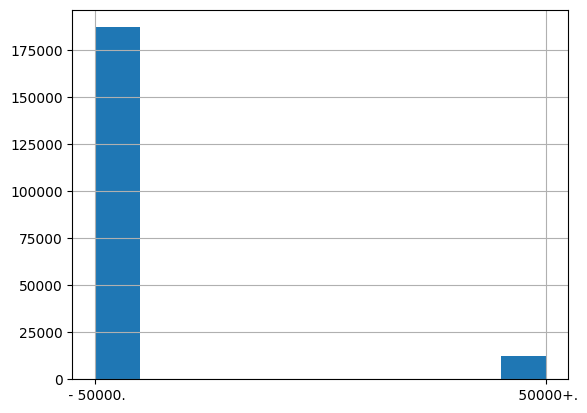

In [6]:
df['income_50k'].hist()
df['income_50k'].value_counts(normalize=True)

## Section 2: Basic inspection of the data

In [7]:
df.describe()

,age,det_ind_code,det_occ_code,wage_per_hour,capital_gains,capital_losses,stock_dividends,num_emp,own_or_self,vet_benefits,weeks_worked,year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,6.000000,2.000000,2.000000,52.000000,95.000000


In [8]:
# count column types
df.dtypes.value_counts()

object    29
int64     12
dtype: int64

C:\Users\joels\AppData\Local\Temp\ipykernel_10528\3584811370.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

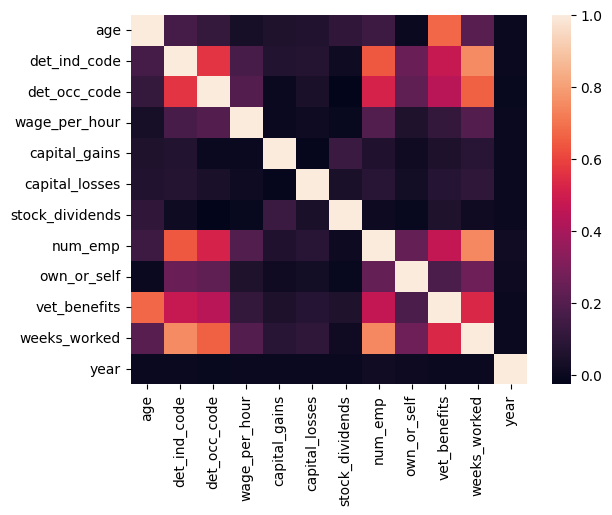

In [9]:
# heatmap of the correlation between the features
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

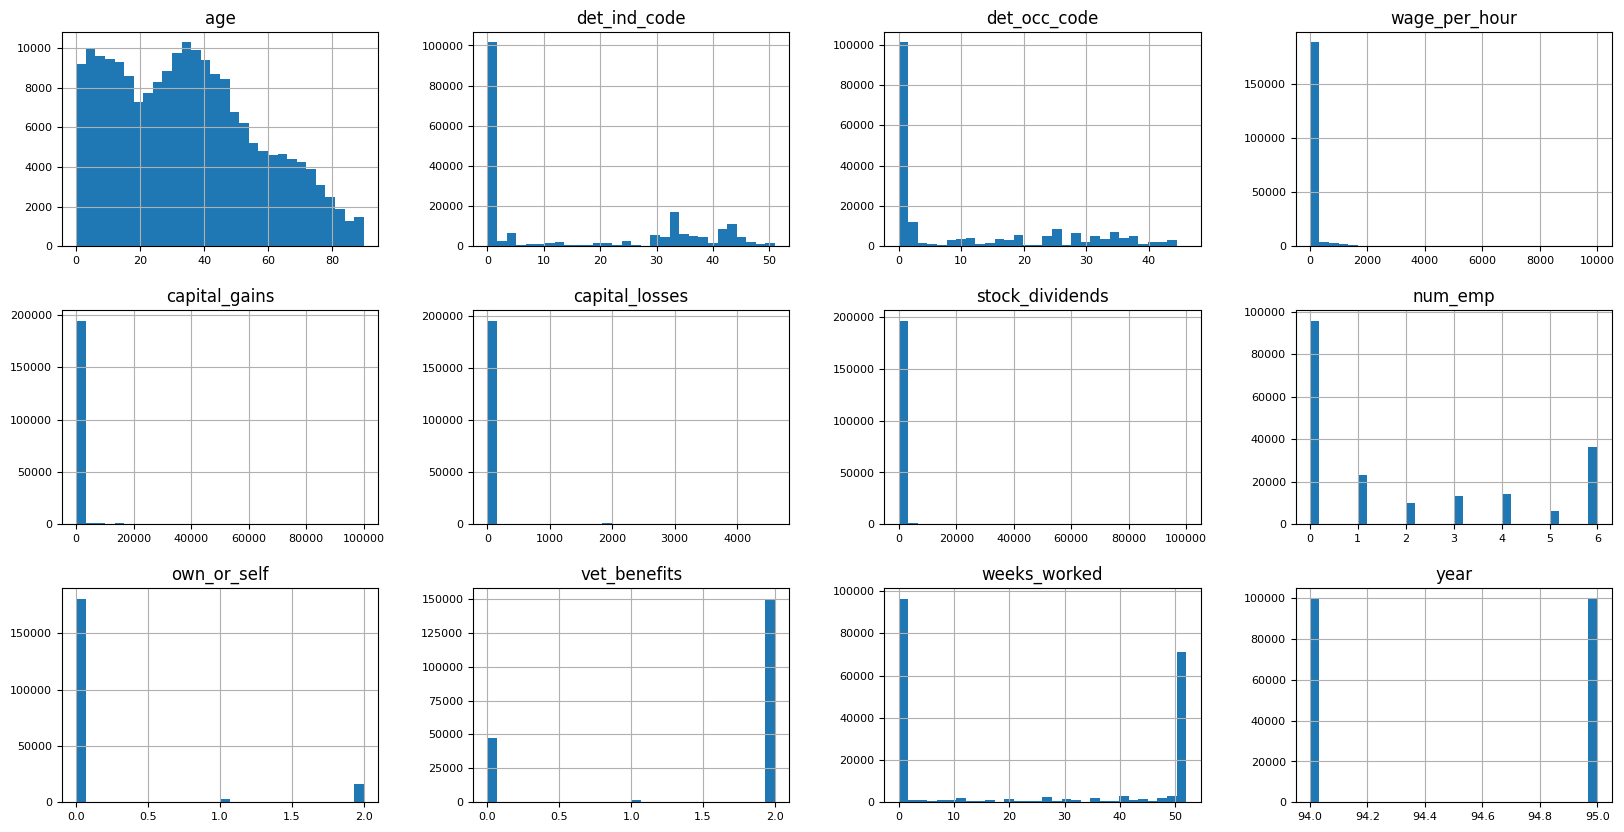

In [10]:
# draw the histograms in a 3 x 4 grid
df.hist(figsize=(20,10), bins=30, xlabelsize=8, ylabelsize=8, layout=(3,4))
plt.savefig('figures/all_num_histograms.pdf')
plt.show()

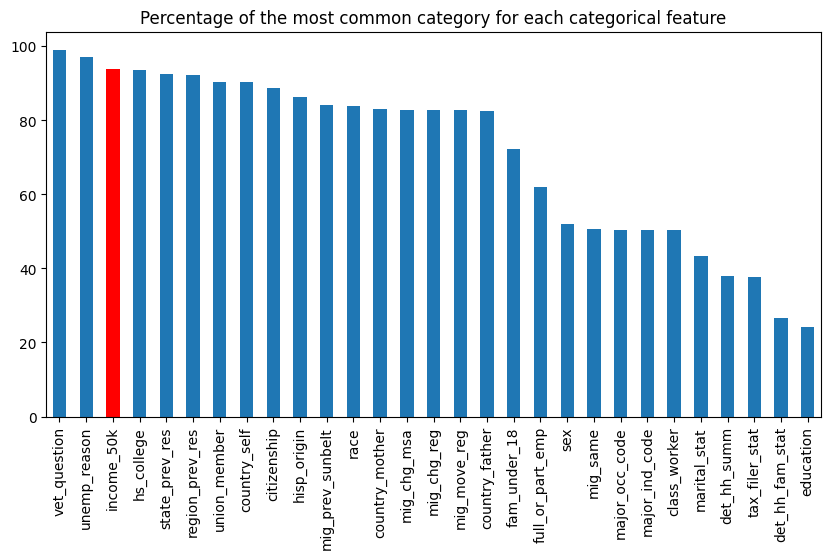

In [11]:
# plot the percentage of the most common category for each categorical feature in a single plot for category vs percentage
a = df.select_dtypes(include=['object']).apply(lambda x: x.value_counts(normalize=True).max()*100)
# sort the values
a = a.sort_values(ascending=False)
# plot the names in diagonal
a.plot(kind='bar', figsize=(10,5))
# plot income_50k bar in red 
plt.bar(a.index.get_loc('income_50k'), a['income_50k'], color='red', width=0.5)
plt.title('Percentage of the most common category for each categorical feature')
plt.savefig('figures/raw_cat_most_common.pdf', bbox_inches='tight')
plt.show()

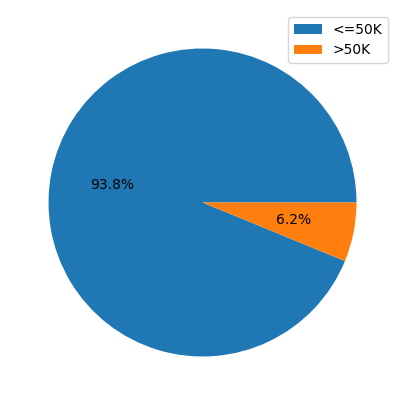

In [12]:
# pieplot of income_50k, change the names of - 50000. and 50000+. to <=50K and >50K
df['income_50k'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5), labels=['', ''])
# keep the original labels
plt.legend(labels=['<=50K', '>50K'])
plt.ylabel('')
plt.savefig('figures/target_freq.pdf')
plt.show()

In [36]:
def pieplots(df, cols, grid=(None,5), figsize=(20, 10), savename=None, other_freq=0.05):
    """
    Plot pieplots for the given columns in a grid of 4 columns.
    """
    if grid[0] is None:
        grid = (int(np.ceil(len(cols) / grid[1])), grid[1])
    # create a figure and a grid of subplots
    fig, ax = plt.subplots(grid[0], grid[1], figsize=figsize)
    for variable, subplot in zip(cols, ax.flatten()):
        counts = df[variable].value_counts(normalize=True)
        counts = counts[counts > other_freq]
        if 1 - counts.sum() > 0:
            counts['other'] = 1 - counts.sum()
        counts.plot.pie(ax=subplot, autopct='%1.1f%%')
        subplot.set_title(variable)
        subplot.set_ylabel('')

    # remove unused graphs
    for i in range(len(cols), grid[0]*grid[1]):
        fig.delaxes(ax.flatten()[i])

    # save the figure
    if savename:
        plt.savefig(savename, bbox_inches='tight')
    plt.show()

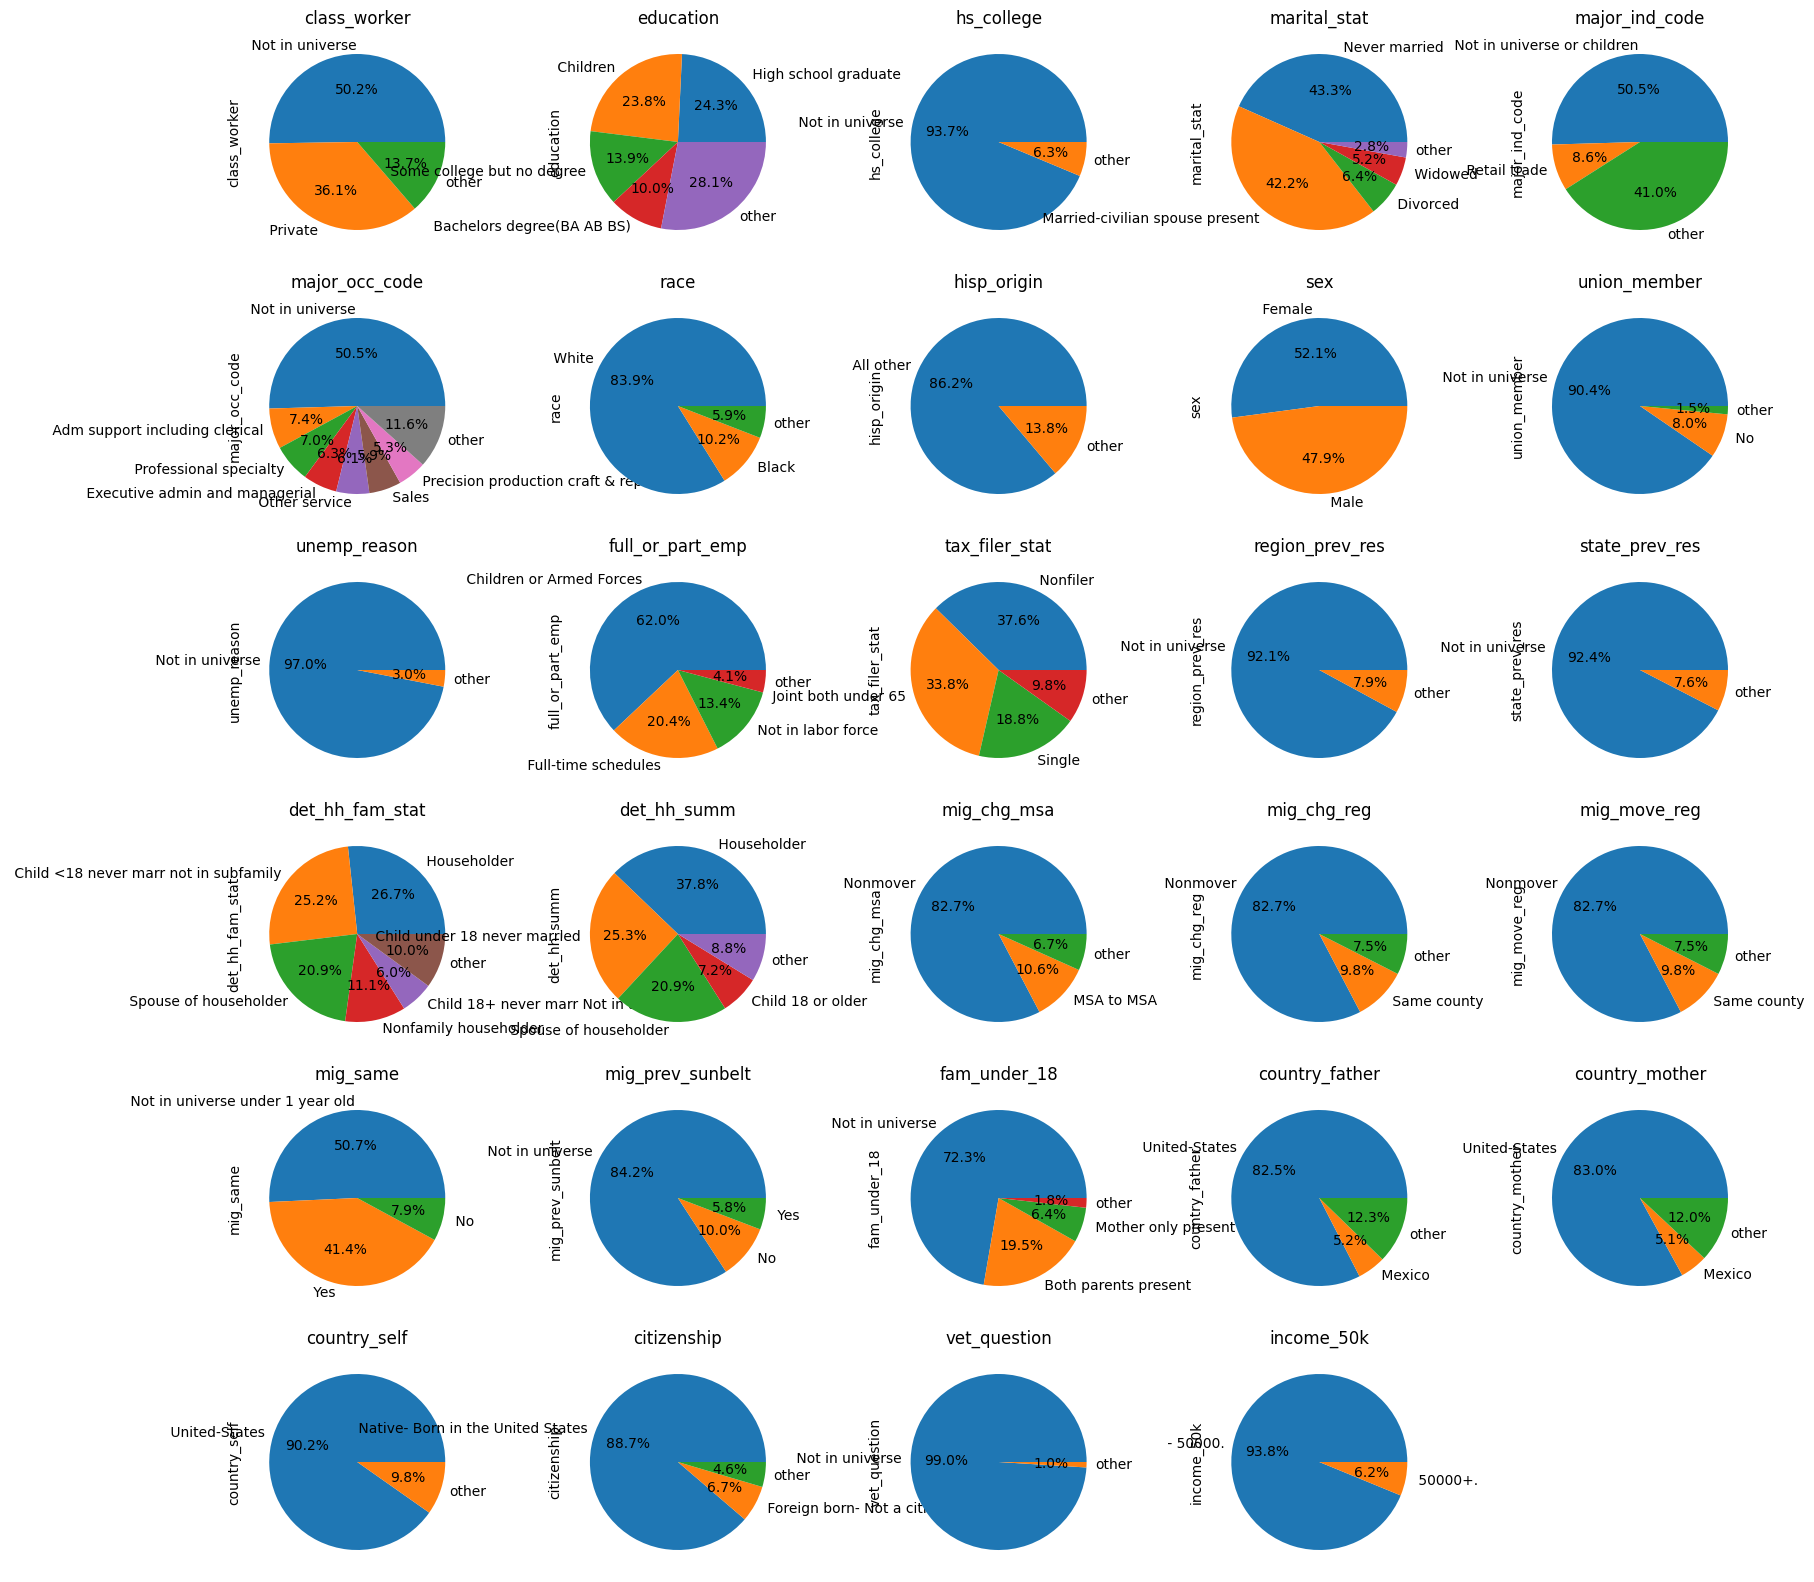

In [14]:
cat_col = df.select_dtypes(include=['object']).columns
pieplots(df, cat_col, figsize=(20, 20))

## Section 3: Data cleaning

In [15]:
df1 = df.copy()

# we remove year since there are 2 years and is not relevant
# df1 = df1.drop('year', axis=1)

To avoid having correlation between the rows, we drop the duplicates.

In [16]:
# show the number of duplicates
print(f"Number of duplicates: {df1.duplicated().sum()}")
df1 = df1.drop_duplicates()
print(f"Number of rows after removing duplicates: {df1.shape[0]}")

Number of duplicates: 46627
Number of rows after removing duplicates: 152896


### Missing values detection

In [17]:
df1.describe()

,age,det_ind_code,det_occ_code,wage_per_hour,capital_gains,capital_losses,stock_dividends,num_emp,own_or_self,vet_benefits,weeks_worked,year
count,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000
mean,39.719371,19.942922,14.672876,72.324279,567.237115,48.664471,257.019255,2.538052,0.228587,1.821061,30.061591,94.490163
std,19.662074,18.234760,14.887964,312.072448,5359.204656,309.511387,2261.405280,2.403920,0.622317,0.559472,23.786471,0.499905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,38.000000,24.000000,10.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,45.000000,94.000000
75%,52.000000,37.000000,29.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.000000,4608.000000,99999.000000,6.000000,2.000000,2.000000,52.000000,95.000000


<Axes: >

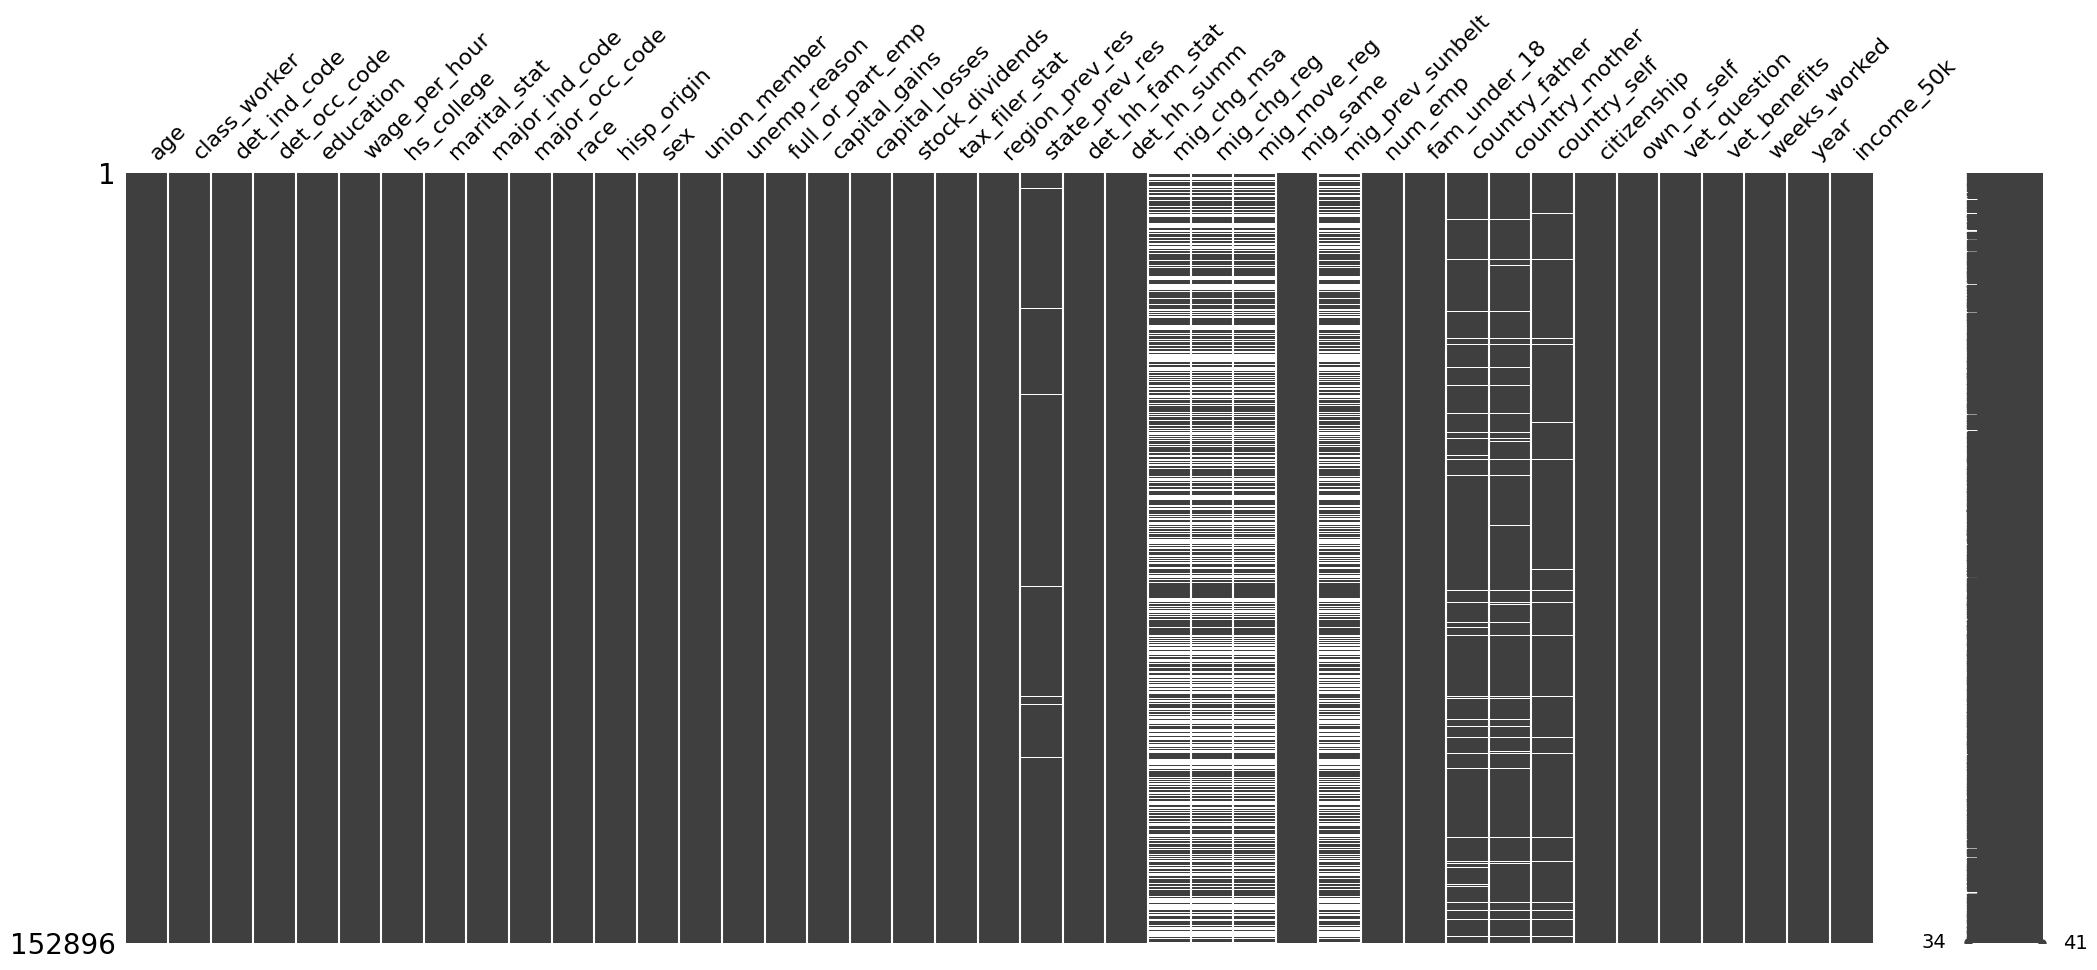

In [18]:
# plot the missing values
import missingno as msno
msno.matrix(df1)

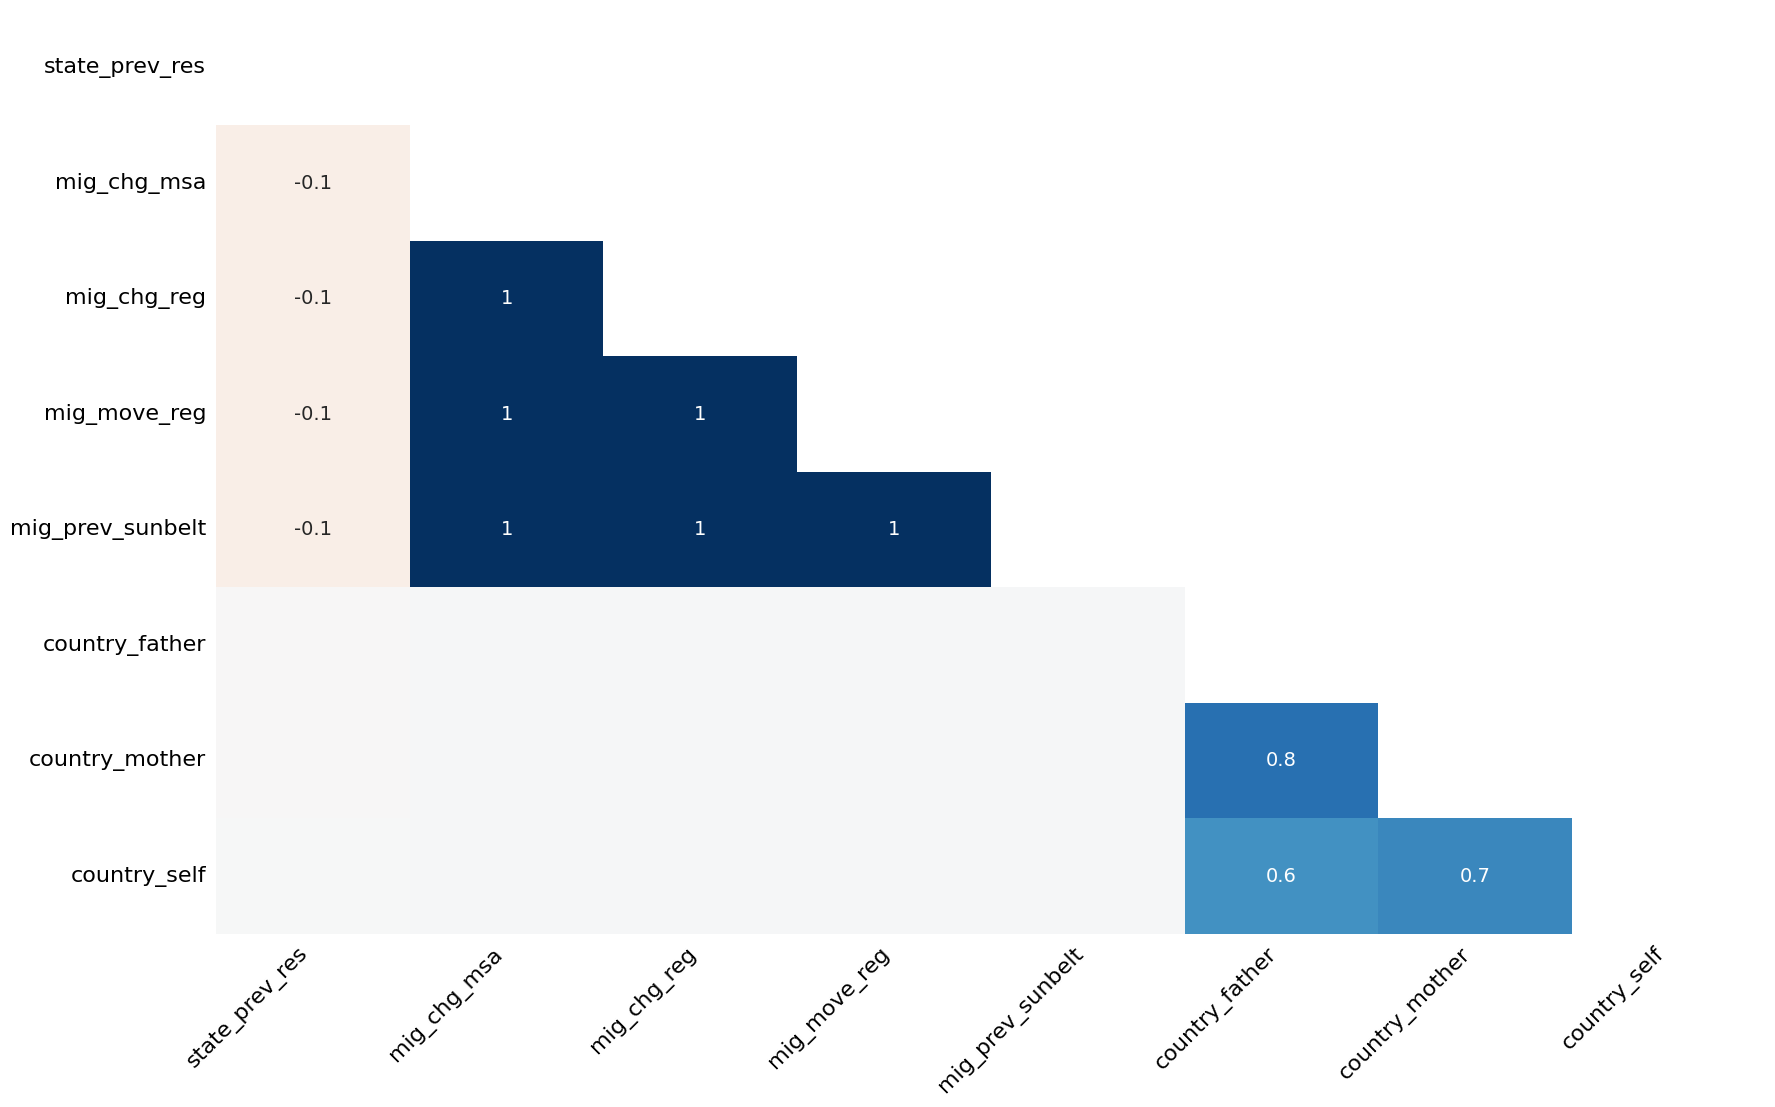

In [19]:
# plot the correlation between the missing values without the colorbar
msno.heatmap(df1, cbar=False)
# save the figure
plt.savefig('figures/missing_corr_heatmap.pdf', bbox_inches='tight')
plt.show()

We can see that the categories "mig_chg_msa", "mig_chg_reg", and "mig_move_reg" have a correlation of 1 with the target variable.

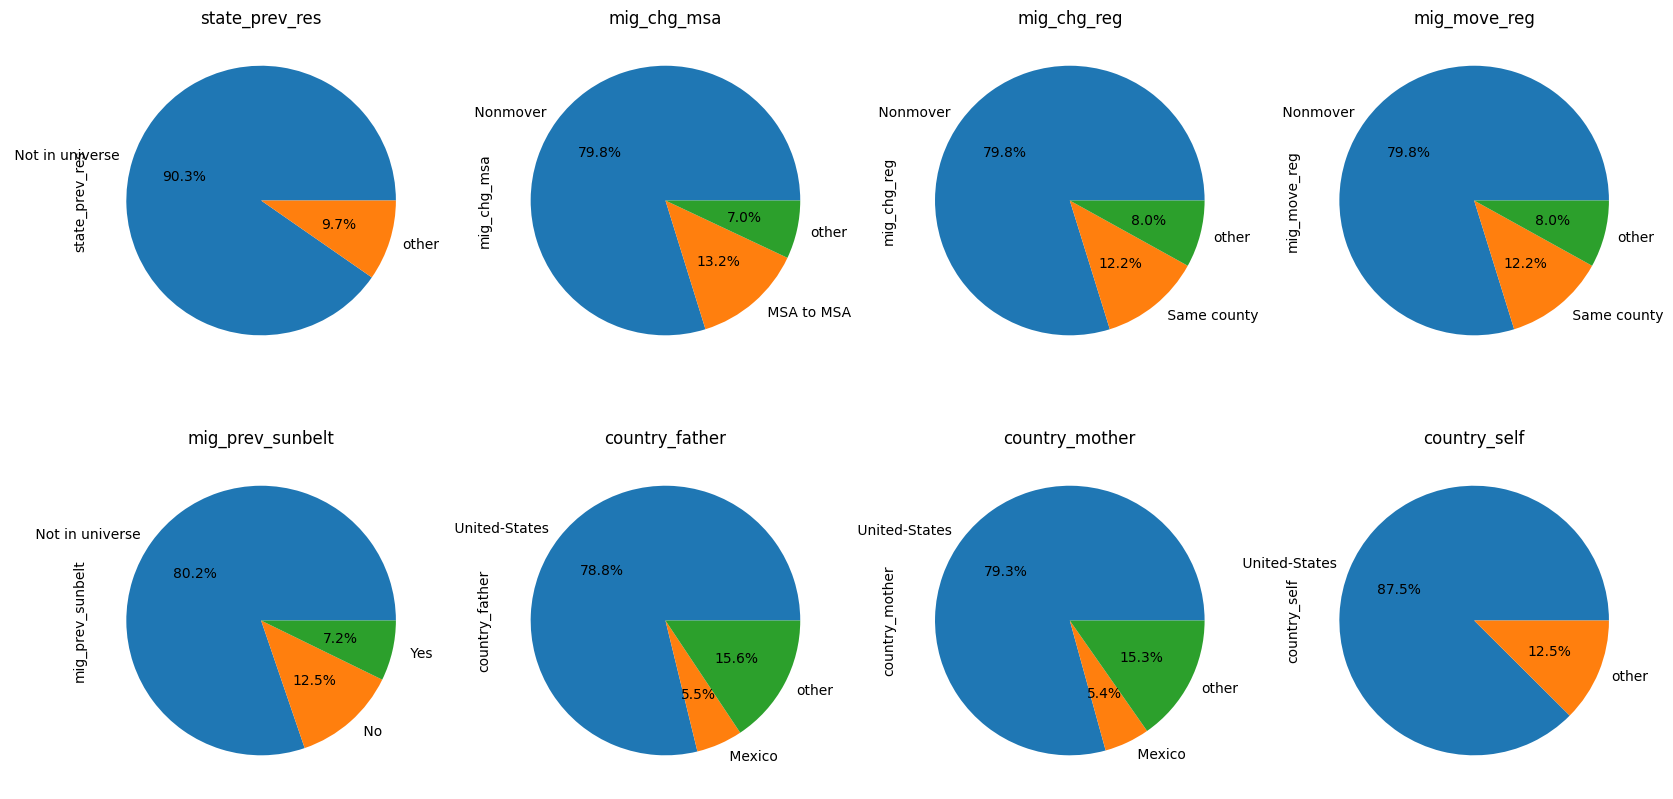

In [20]:
cols_with_missing = df1.columns[df1.isnull().any()]
pieplots(df1, cols_with_missing,grid=(2,4), figsize=(20, 10))

### Treating missing values

In [21]:
print("Percentage of missing values per column:")
print(df1.isnull().sum()[df1.isnull().sum() > 0] / df1.shape[0])

Percentage of missing values per column:
state_prev_res      0.004565
mig_chg_msa         0.490163
mig_chg_reg         0.490163
mig_move_reg        0.490163
mig_prev_sunbelt    0.490163
country_father      0.041747
country_mother      0.038000
country_self        0.021727
dtype: float64


In [22]:
# we drop the columns with more than 40% of missing values
print(f"dropping columns: {cols_with_missing[df1[cols_with_missing].isnull().mean() > 0.4]}")
df1 = df1.drop(cols_with_missing[df1[cols_with_missing].isnull().mean() > 0.4], axis=1)
print(df1.isnull().sum()[df1.isnull().sum() > 0] / df1.shape[0])
cols_with_missing = df1.columns[df1.isnull().any()]

dropping columns: Index(['mig_chg_msa', 'mig_chg_reg', 'mig_move_reg', 'mig_prev_sunbelt'], dtype='object')
state_prev_res    0.004565
country_father    0.041747
country_mother    0.038000
country_self      0.021727
dtype: float64


<Axes: >

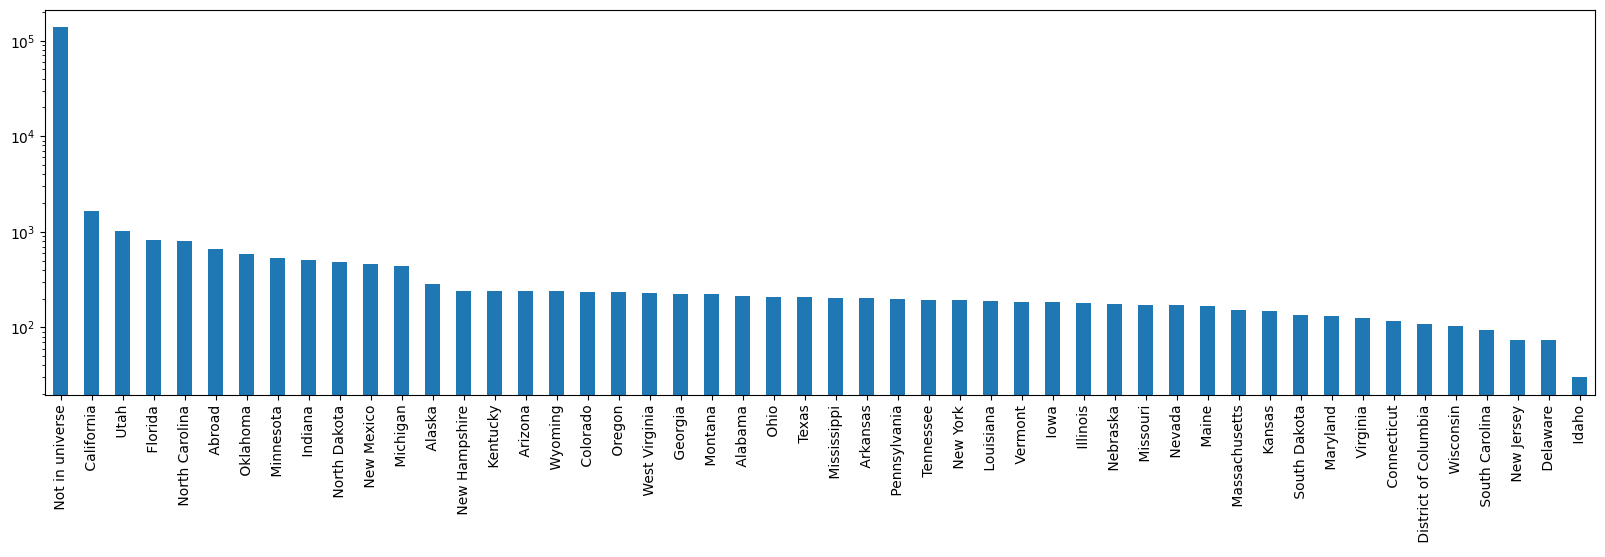

In [23]:
df1['state_prev_res'].value_counts().plot(kind='bar', logy=True, figsize=(20, 5))

since the columns state_prev_res, country_father, country_mother, and country_self have less than 5% of missing values, we can imputate them with the most frequent value.

In [24]:
# we fill the missing values with the most frequent value
cols_with_missing = df1.columns[df1.isnull().any()]
print(cols_with_missing)
for col in cols_with_missing:
    df1[col] = df1[col].fillna(df1[col].value_counts().index[0])  
print(f"Missing values: {sum(df1.isnull().sum())}")

Index(['state_prev_res', 'country_father', 'country_mother', 'country_self'], dtype='object')
Missing values: 0


### Converting numerical variables to categorical

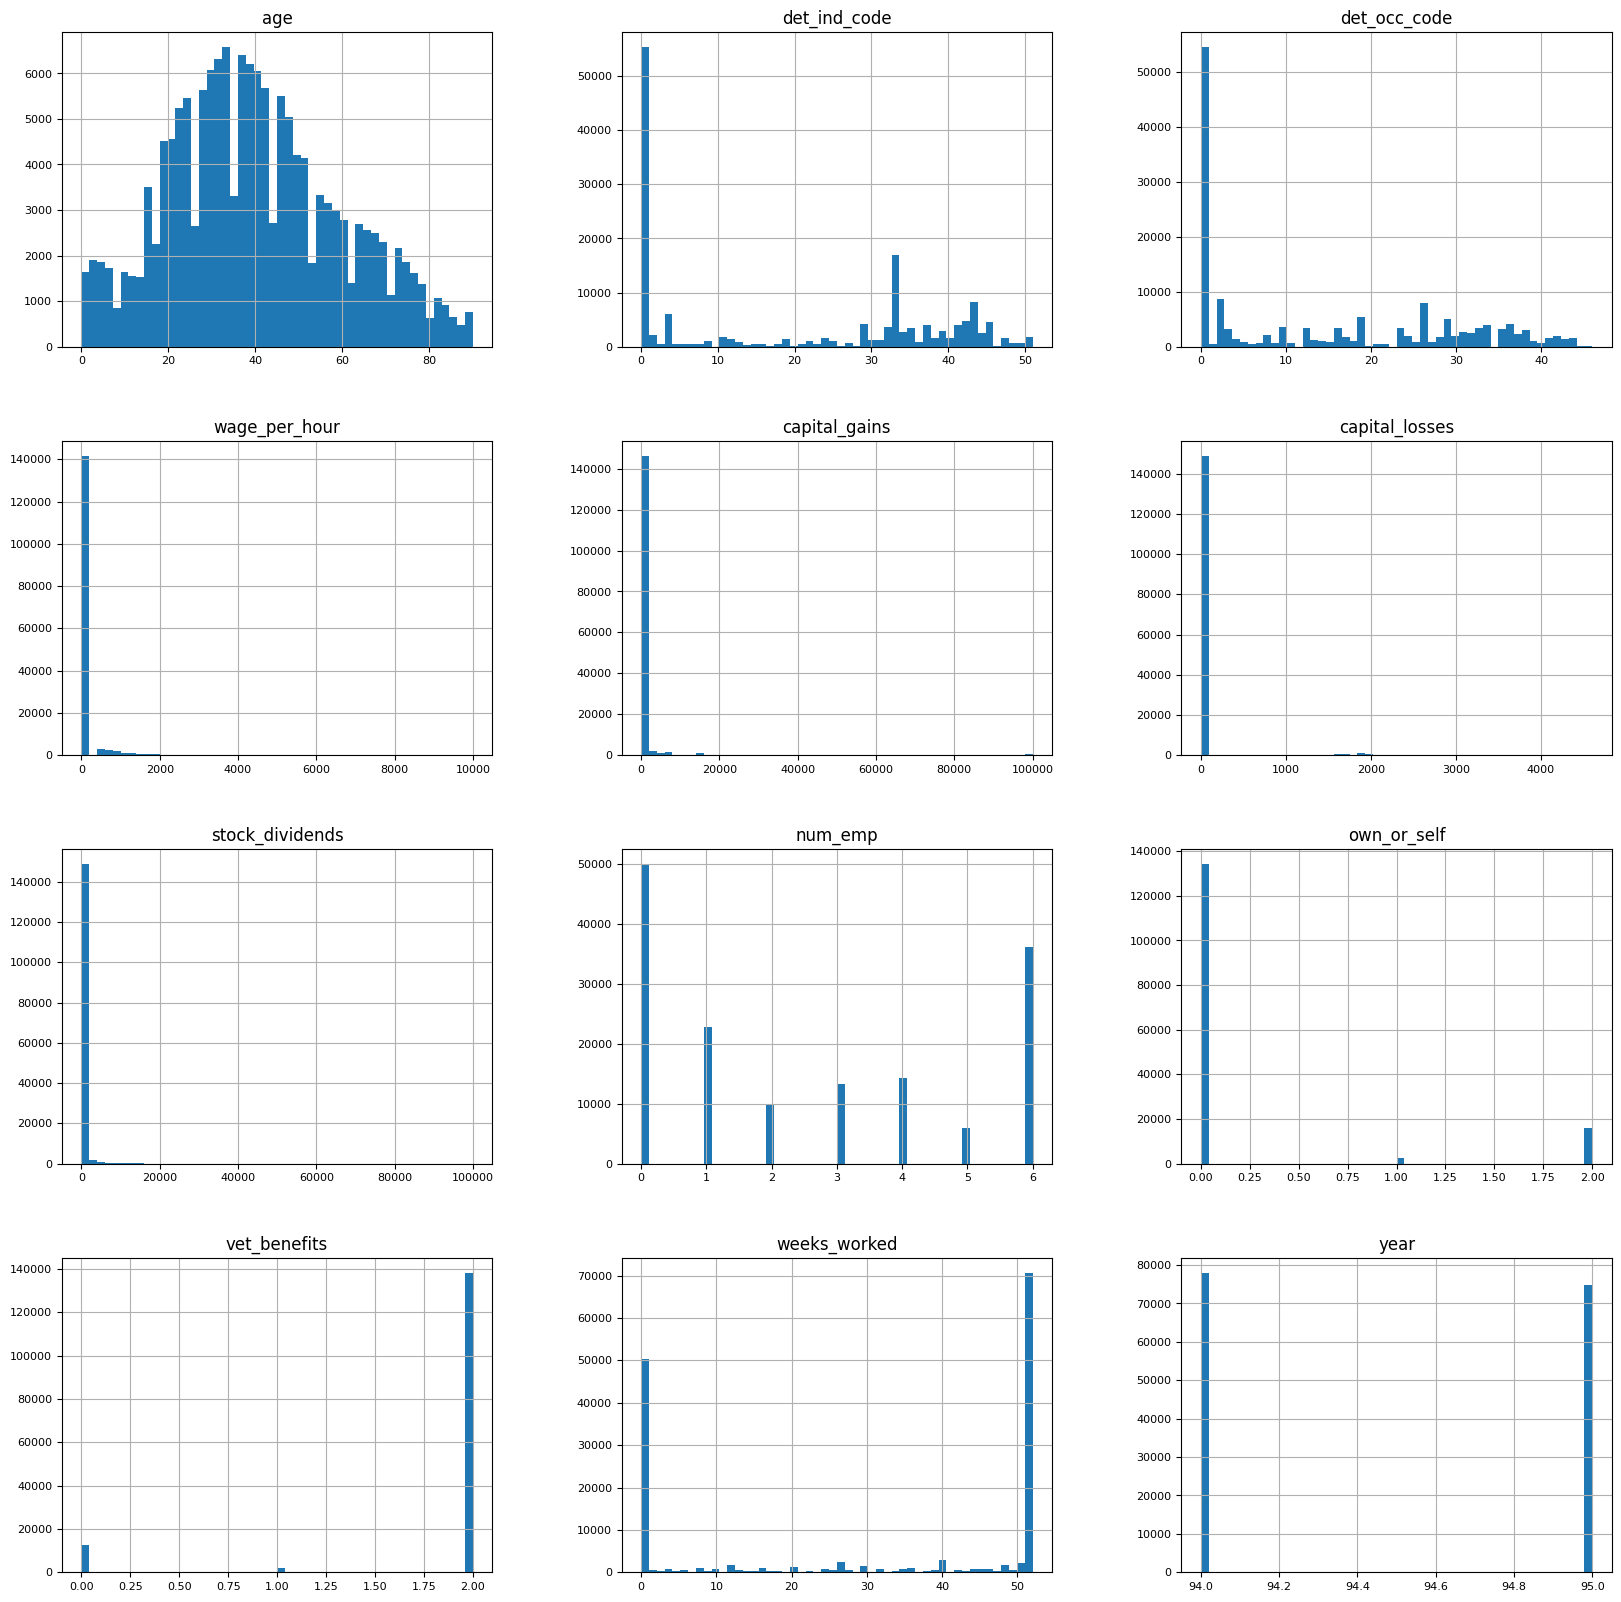

In [25]:
df1.hist(figsize=(20,20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

In [26]:
# categorical columns hidden as numerical
for col in ['det_ind_code', 'det_occ_code', 'own_or_self', 'vet_benefits', 'year']:
    df1[col] = df1[col].astype('category')

In [27]:
age_bins = [0, 18, 25, 35, 45, 55, 65, 75, 85, 95, 105]
df1['age'] = pd.cut(df1['age'], bins=age_bins, labels=age_bins[:-1])

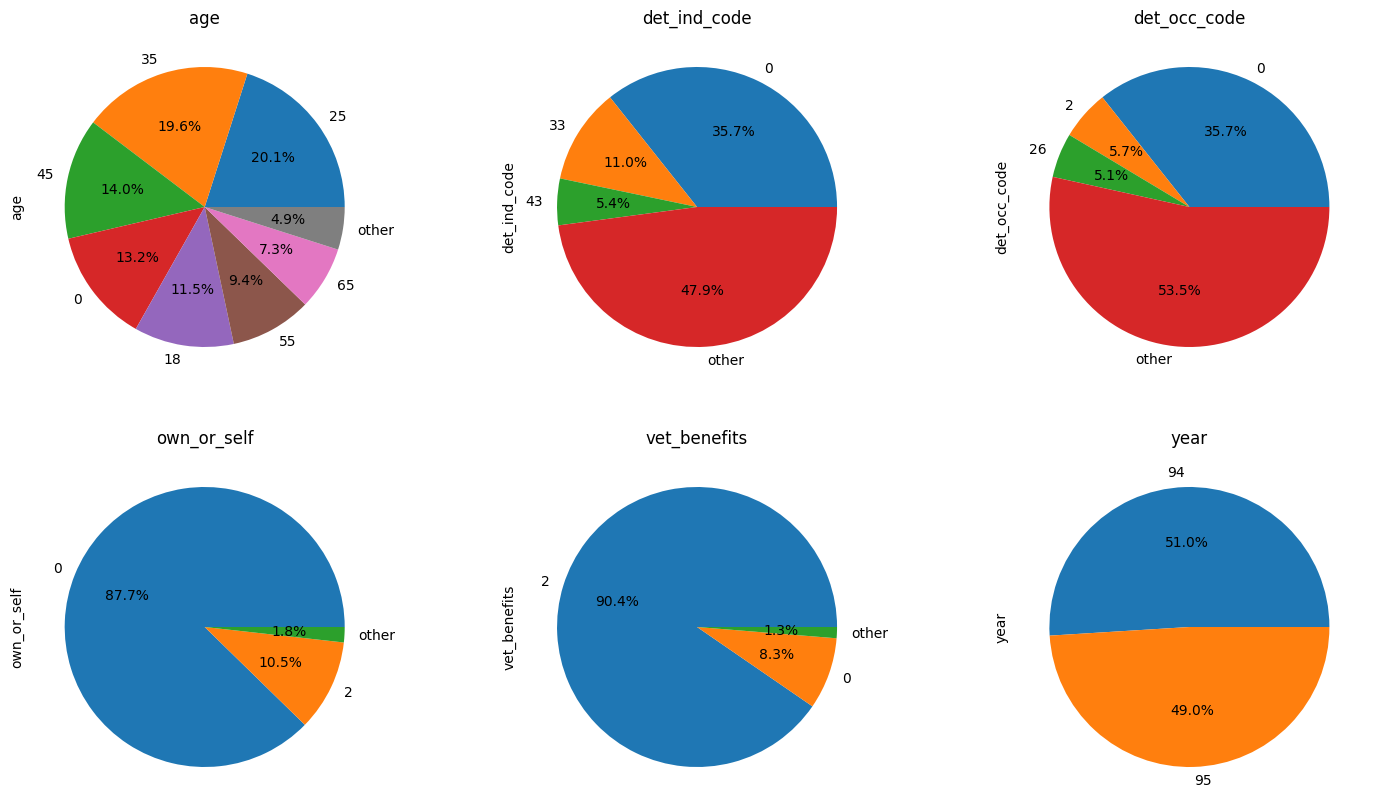

In [28]:
pieplots(df1, ['age', 'det_ind_code', 'det_occ_code', 'own_or_self', 'vet_benefits', 'year'],
         grid=(2,3), figsize=(18, 10), savename='figures/num_conv_pieplots.pdf')

remaining numerical features

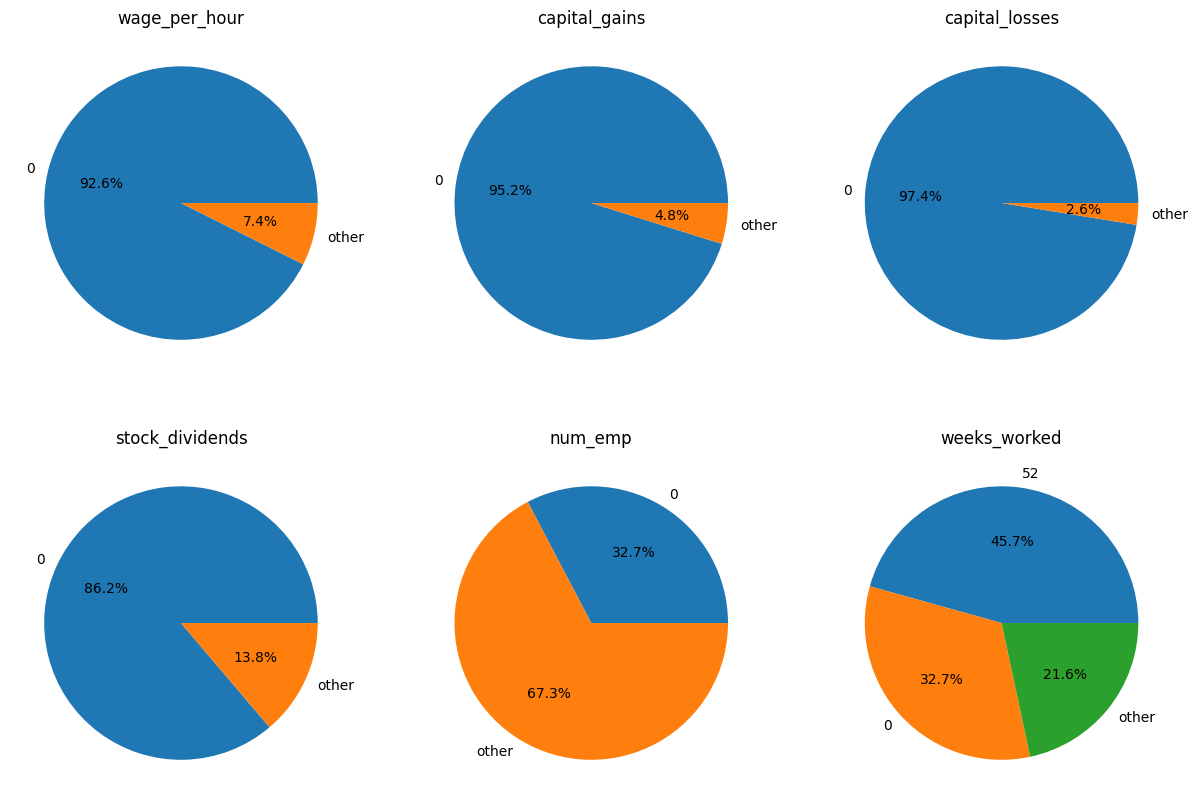

In [39]:
num_col = df1.select_dtypes(include=['int64', 'float64']).columns

pieplots(df1, num_col, grid=(2,3), figsize=(15, 10), other_freq=0.3, savename='figures/num_pieplots.pdf')

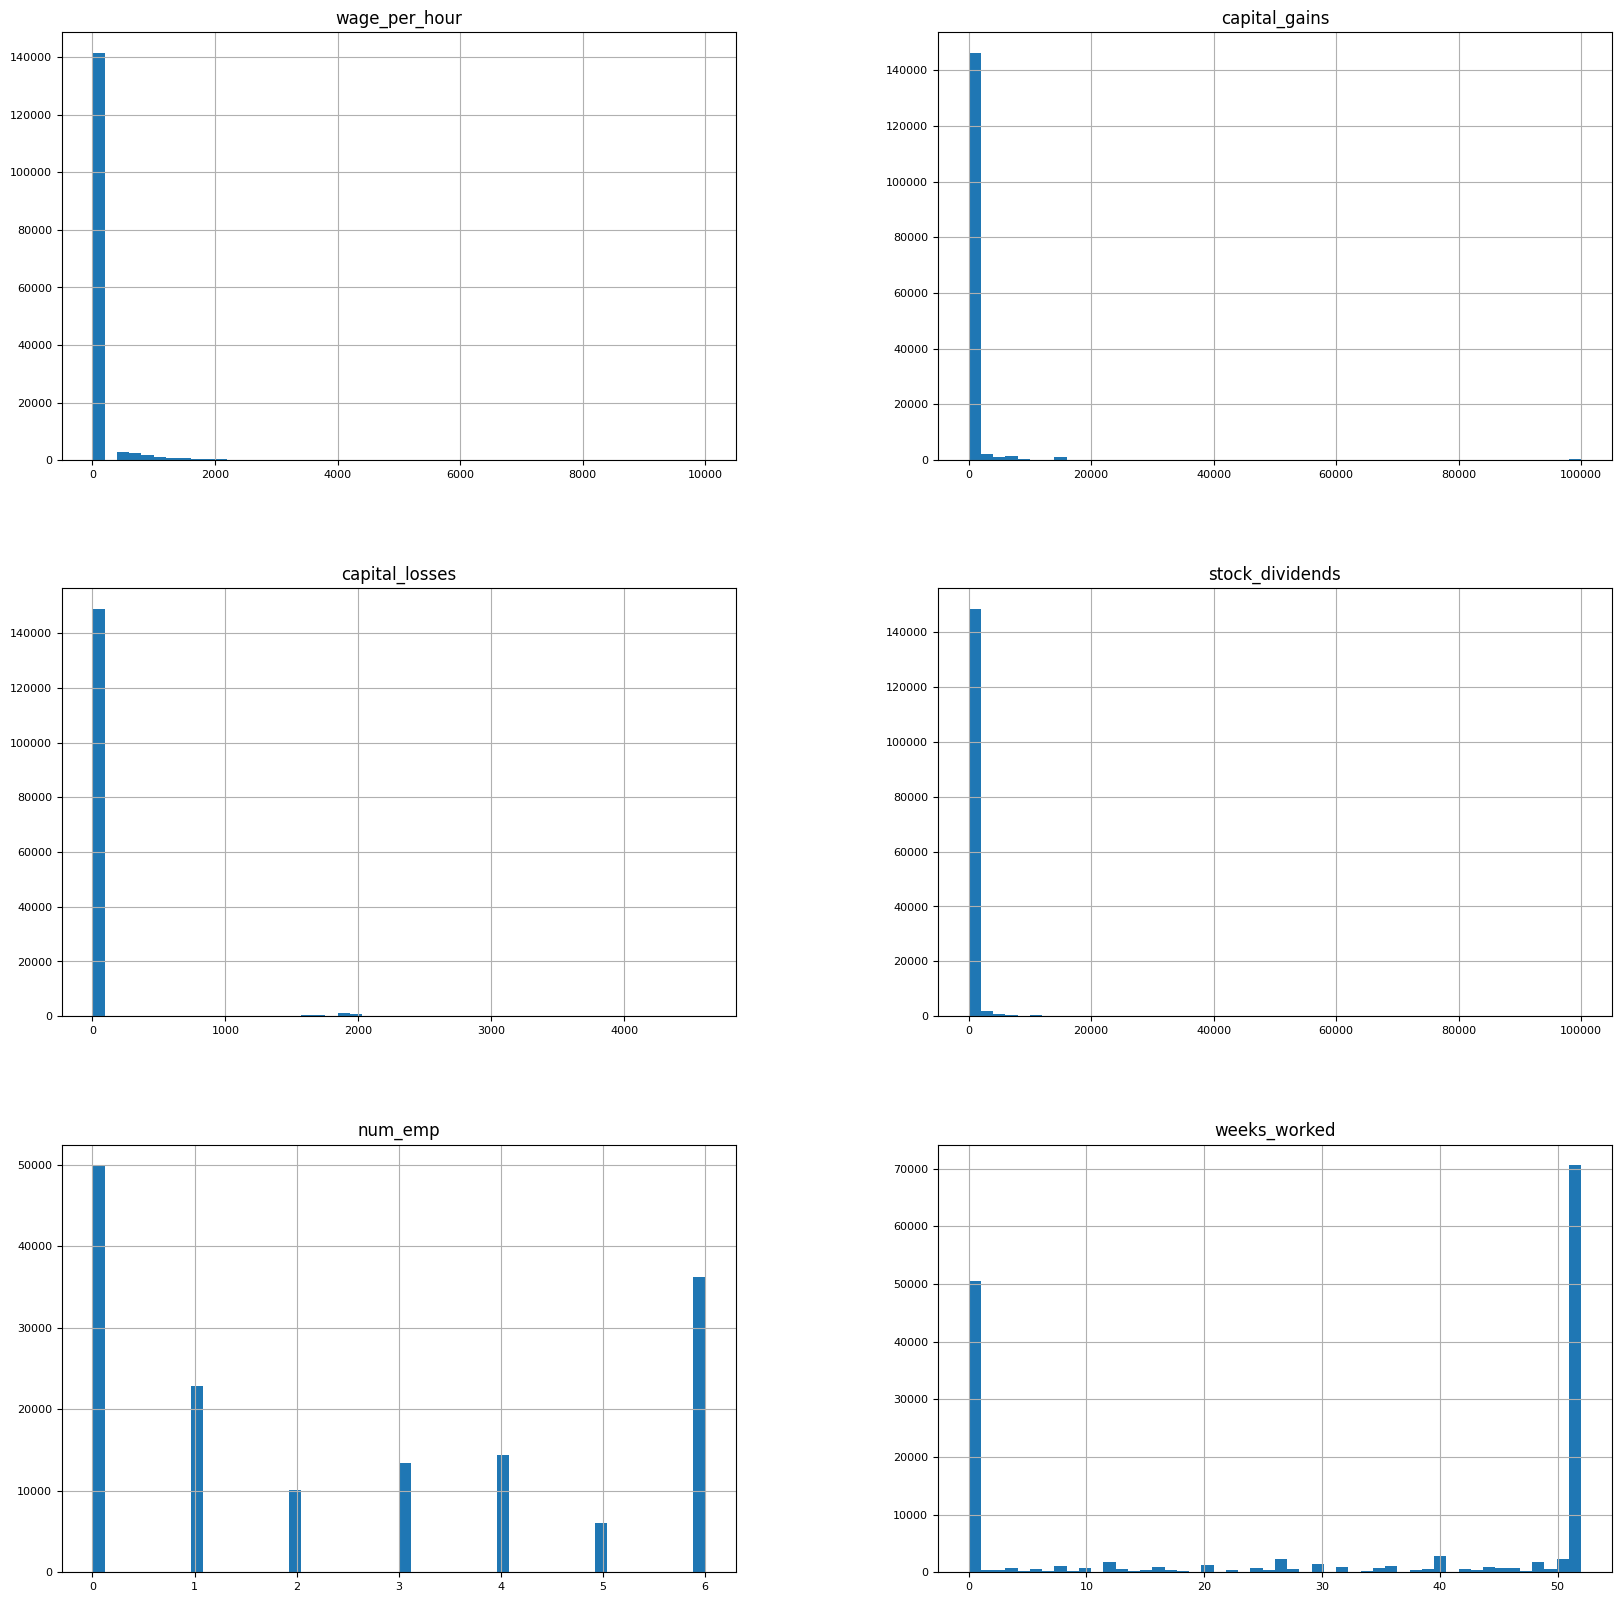

In [30]:
df1.hist(figsize=(20,20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

since most of the values of wage_per_hour, capital_gains, capital_losses, and stock_dividends are 0, we can binarize them.

In [31]:
binarized_cols = ['wage_per_hour', 'capital_gains', 'capital_losses', 'stock_dividends']
for col in binarized_cols:
    df1[col] = df1[col].apply(lambda x: 0 if x == 0 else 1)
    df1[col] = df1[col].astype('category')

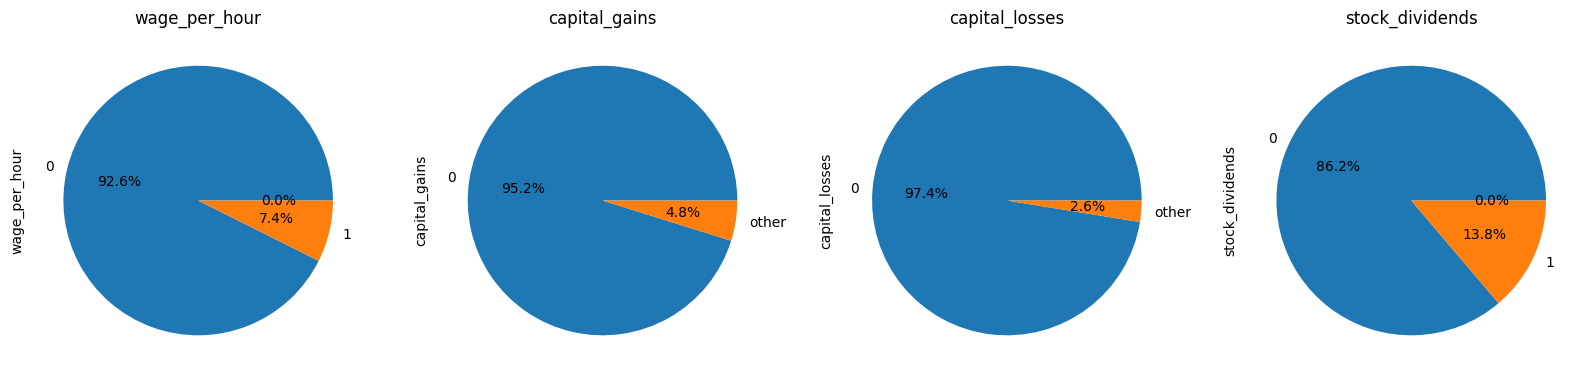

In [32]:
# pieplot for each binarized_cols
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
for variable, subplot in zip(binarized_cols, ax.flatten()):
    # pieplot, merge categories with less than 5% into 'other'
    counts = df1[variable].value_counts(normalize=True)
    counts = counts[counts > 0.05]
    counts['other'] = 1 - counts.sum()
    counts.plot.pie(ax=subplot, autopct='%1.1f%%')
    subplot.set_title(variable)

# save the figure
plt.savefig('figures/binarized_cols.pdf', bbox_inches='tight')
plt.show()

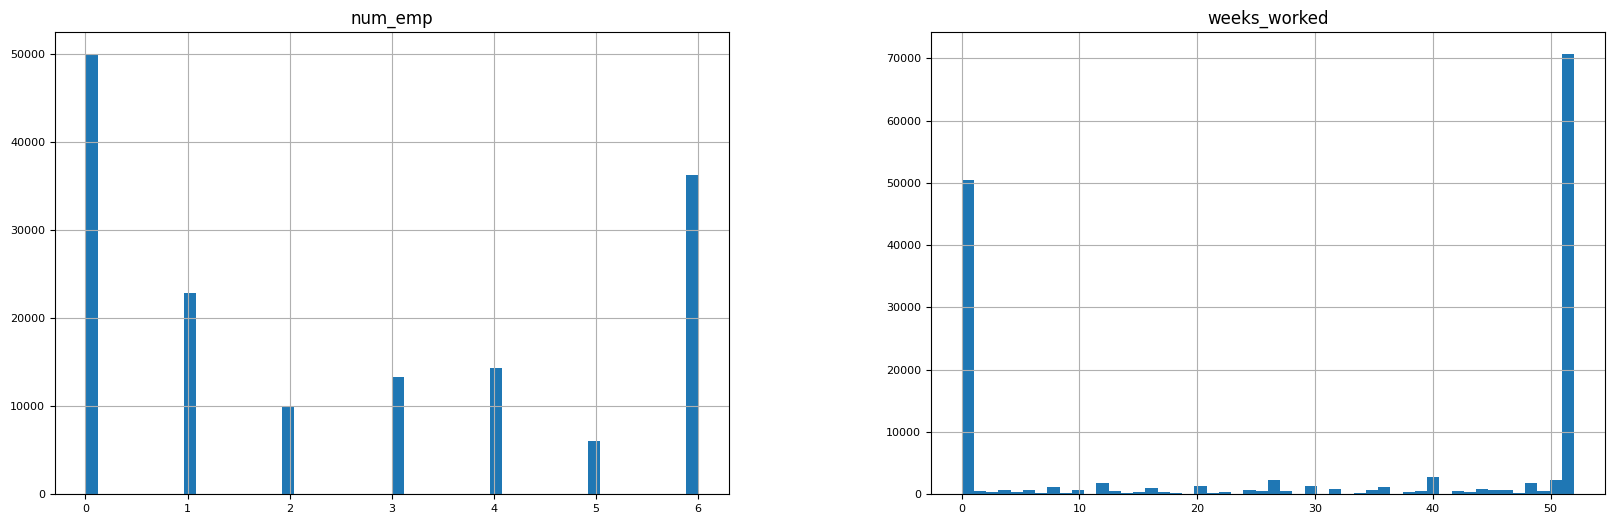

In [33]:
df1.hist(figsize=(20,6), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

To categorize the remaining numerical variables, we can:
convert num_emp to categorical with categories from 0 to 6
convert weeks_worked to categorical with 3 categories (since the distribution is skewed on both sides) one category for 0, one for 1-51, and one for 52

In [34]:
df1['num_emp'] = df1['num_emp'].astype('category')
df1['weeks_worked'] = df1['weeks_worked'].apply(lambda x: 0 if x == 0 else (1 if x <= 51 else 2))
df1['weeks_worked'] = df1['weeks_worked'].astype('category')

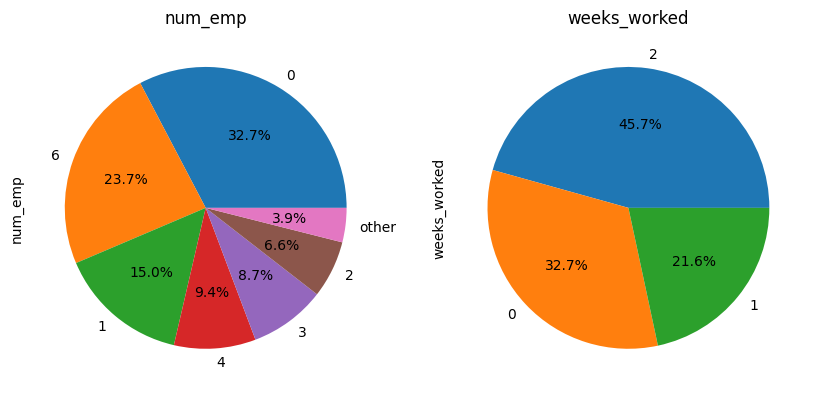

In [35]:
# pieplot for num_emp and weeks_worked
pieplots(df1, ['num_emp', 'weeks_worked'], grid=(1,2), figsize=(10, 5))

In [36]:
# convert all object columns to category
for col in df1.select_dtypes(include=['object']).columns:
    df1[col] = df1[col].astype('category')

# Model adjustment

## Logistic regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df_lr = df1.copy()

df_lr['income_50k'] = np.where(df_lr['income_50k'] == ' - 50000.', 0, 1)

X = df_lr.drop('income_50k', axis=1)
y = df_lr['income_50k']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9357736161677822


#### Model results:
accuracy: (base with 100 iterations)

base model: 0.937942<br>
without treatment: 0.949404<br>
categorical conversion: 0.947450<br>
full categorical conversion: 0.935708<br>
full categorical conversion (with 1000 iterations): 0.935751

## Decision tree

In [42]:
# adjust a decision tree classifier
from sklearn.tree import DecisionTreeClassifier

df_dt = df1.copy()
df_dt['income_50k'] = np.where(df_dt['income_50k'] == ' - 50000.', 0, 1)

X = df_dt.drop('income_50k', axis=1)
y = df_dt['income_50k']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

dt = DecisionTreeClassifier(max_depth=30, min_samples_leaf=0.1, random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9189430770236979


## Random forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df_rf = df1.copy()
df_rf['income_50k'] = np.where(df_rf['income_50k'] == ' - 50000.', 0, 1)

X = df_rf.drop('income_50k', axis=1)
y = df_rf['income_50k']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# train models with different parameters
n_estimators = 22
max_depth = 30

t1 = time.time()
rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)} n_estimators={n_estimators}, max_depth={max_depth} in {time.time() - t1:.2f} seconds")

Accuracy: 0.9331138677538207 n_estimators=22, max_depth=30 in 10.23 seconds


#### Model results:

base model: 0.95417<br>
full categorical conversion: 0.933114<br>
semi categorical conversion: 0.938389<br>